In [37]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using STEP file: D:\workspace\projects\freelance\Fusion3DNet\data\processed\dataset_129\stp\42. Silencer Fix-02.prt.stp


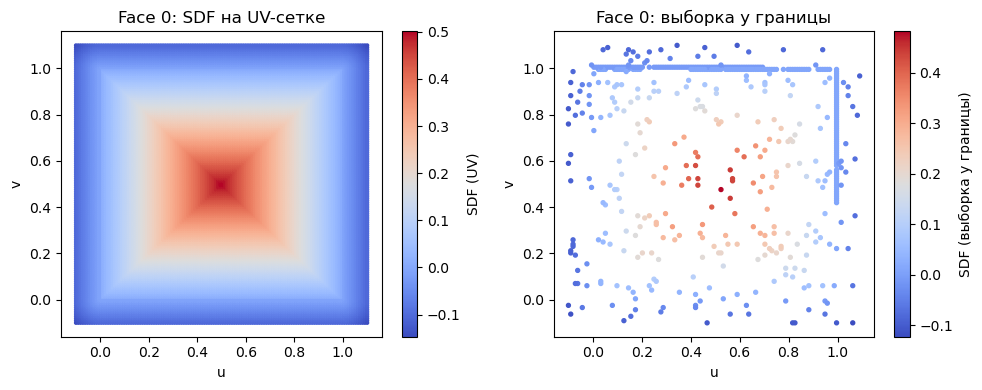

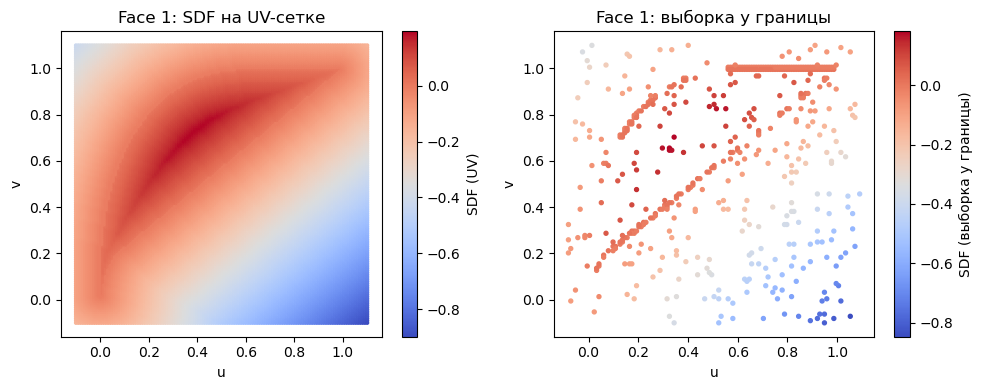

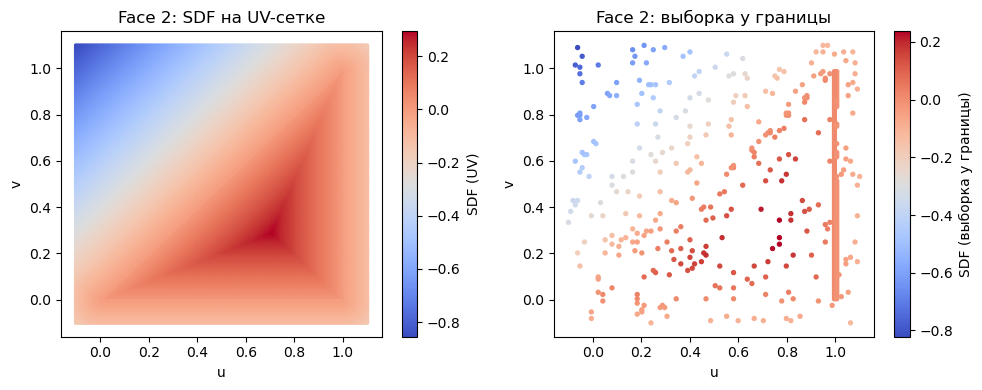

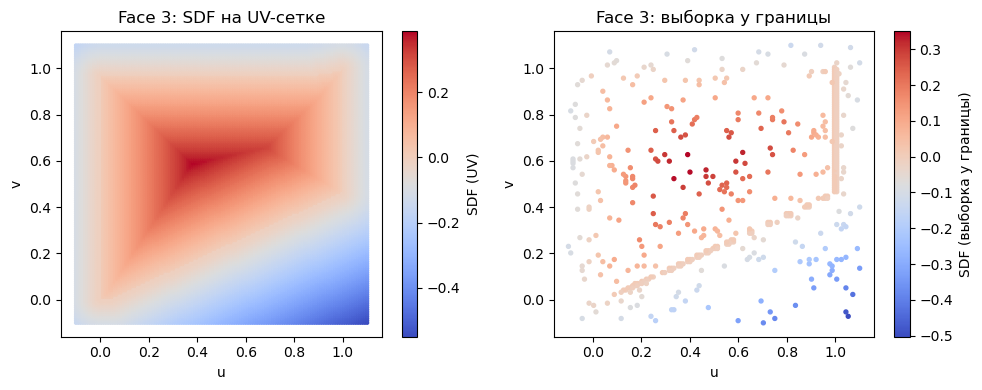

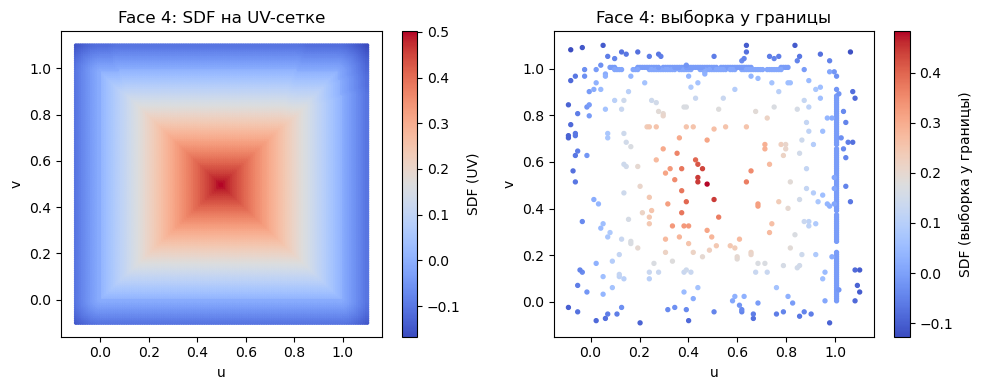

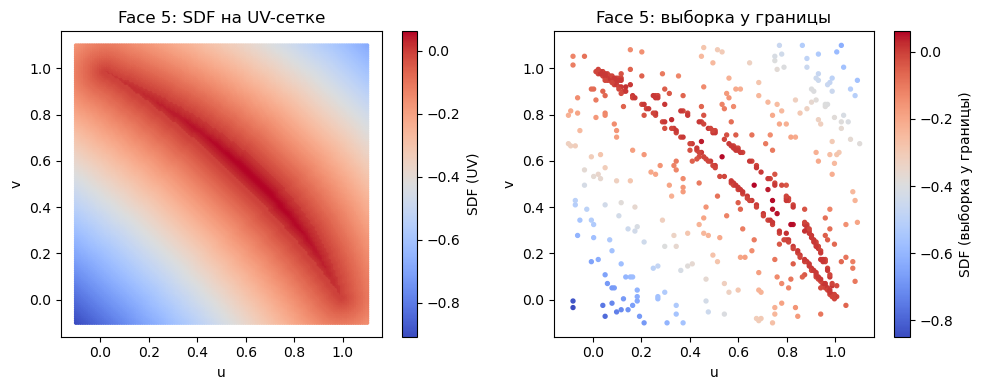

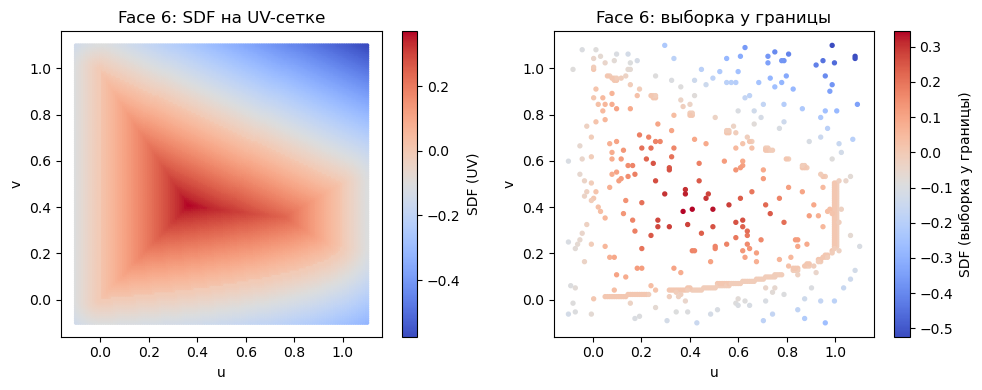

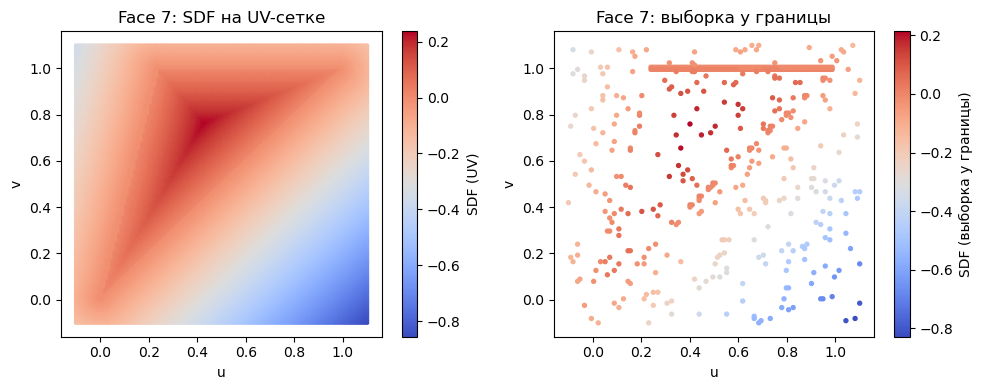

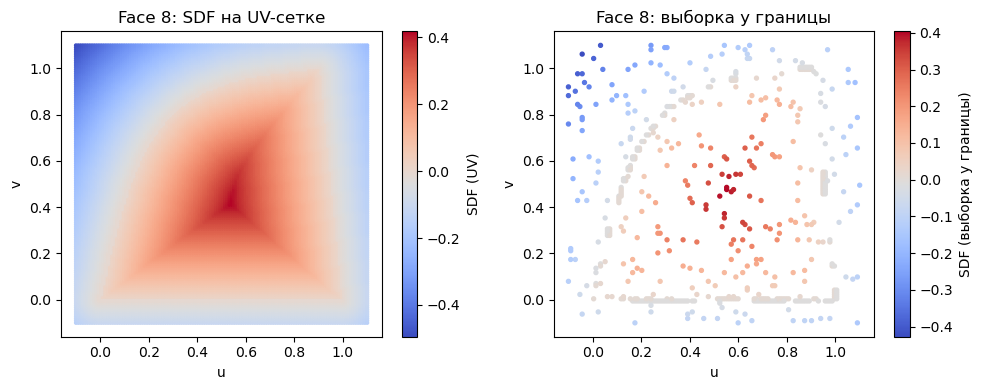

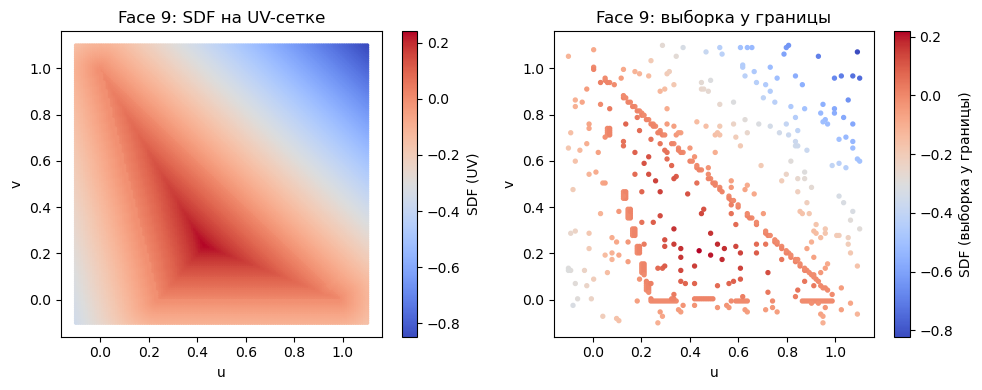

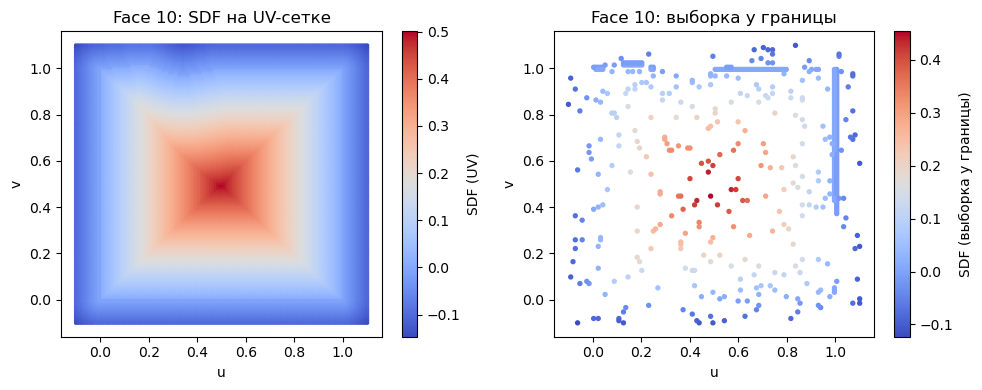

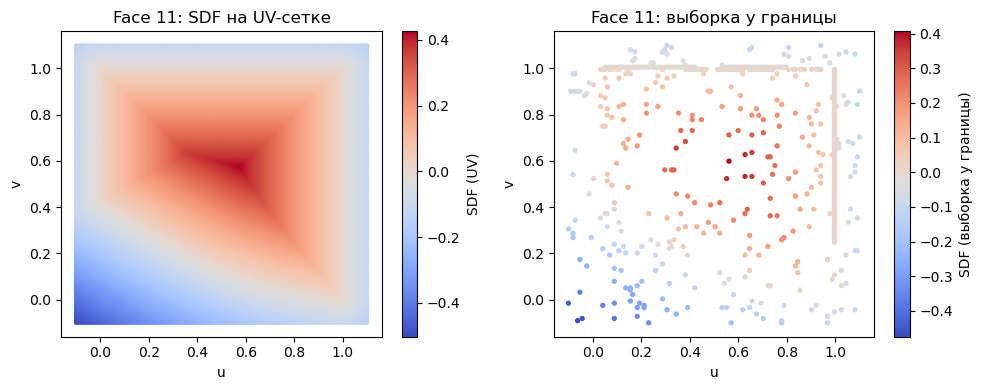

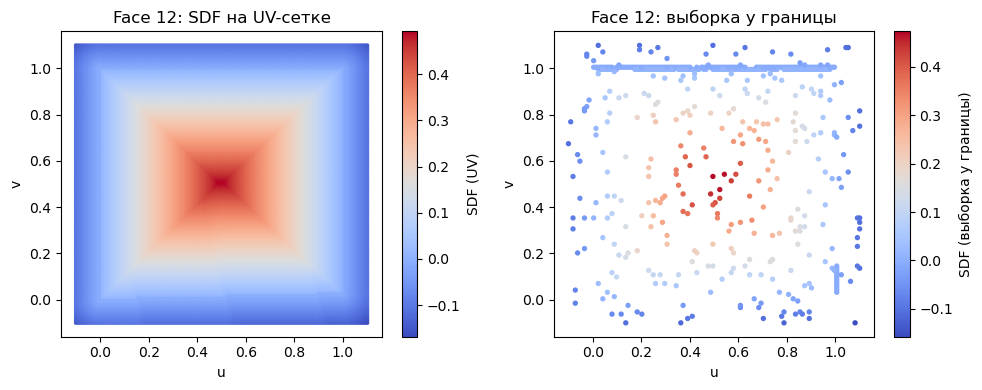

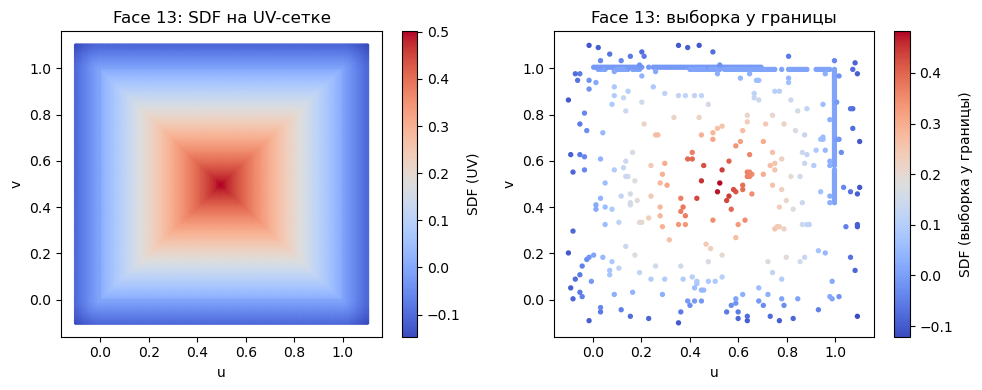

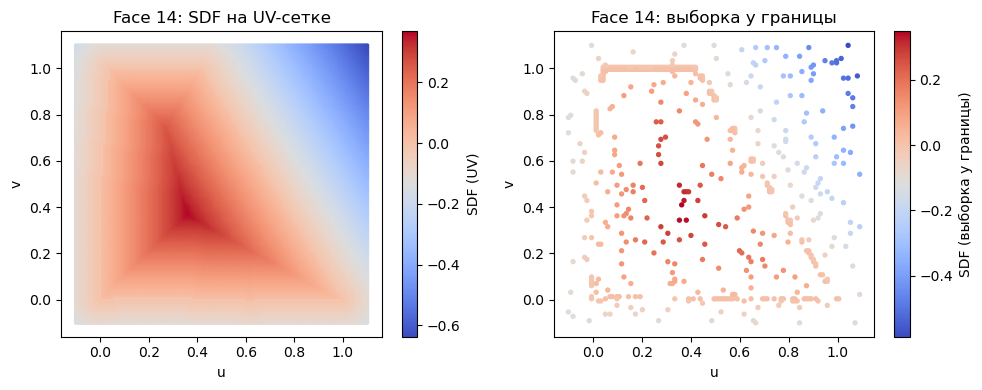

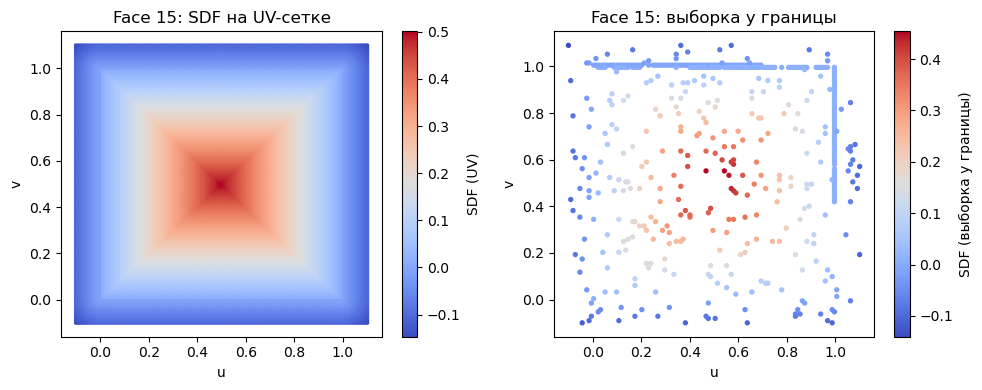

KeyboardInterrupt: 

In [4]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# OCC
from OCC.Core.STEPControl import STEPControl_Reader
from OCC.Core.IFSelect import IFSelect_RetDone
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_FACE, TopAbs_IN
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.BRepClass import BRepClass_FaceClassifier
from OCC.Core.gp import gp_Pnt2d

def ensure_uv_2d(x):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0:
        return np.zeros((0, 2), dtype=np.float32)
    if x.ndim == 2 and x.shape[1] == 2:
        return x
    if x.ndim == 1 and x.shape[0] == 2:
        return x.reshape(1, 2)
    return x.reshape(-1, 2)

def sample_uv_extended(resolution, extend=0.1):
    u = np.linspace(-extend, 1 + extend, resolution)
    v = np.linspace(-extend, 1 + extend, resolution)
    uu, vv = np.meshgrid(u, v, indexing='ij')
    return np.stack([uu.flatten(), vv.flatten()], axis=-1)

def compute_sdf(inside_points, outside_points):
    inside = ensure_uv_2d(inside_points)
    outside = ensure_uv_2d(outside_points)

    if inside.shape[0] == 0 and outside.shape[0] == 0:
        return np.zeros((0, 2), dtype=np.float32), np.zeros((0,), dtype=np.float32)
    if inside.shape[0] == 0:
        return outside, -np.zeros((outside.shape[0],), dtype=np.float32)
    if outside.shape[0] == 0:
        return inside, np.zeros((inside.shape[0],), dtype=np.float32)

    inside_tree = KDTree(outside)
    outside_tree = KDTree(inside)
    d_inside, _ = inside_tree.query(inside)
    d_outside, _ = outside_tree.query(outside)

    sdf_inside = d_inside.astype(np.float32)
    sdf_outside = -d_outside.astype(np.float32)
    sdf_points = np.concatenate([inside, outside], axis=0)
    sdf_values = np.concatenate([sdf_inside, sdf_outside], axis=0)
    return ensure_uv_2d(sdf_points), sdf_values.astype(np.float32)

def bias_sample_sdf(sdf_points, sdf_values, n_samples, boundary_ratio=0.4):
    pts = ensure_uv_2d(sdf_points)
    vals = np.asarray(sdf_values, dtype=np.float32).reshape(-1)
    if pts.shape[0] == 0:
        return pts, vals
    idx = np.argsort(np.abs(vals))
    nb = int(n_samples * boundary_ratio)
    nb = max(0, min(nb, idx.size))
    i_boundary = idx[:nb]
    i_pool = idx[nb:]
    if i_pool.size:
        i_pool = np.random.permutation(i_pool)
    need_rand = max(0, n_samples - nb)
    i_sel = np.concatenate([i_boundary, i_pool[:min(need_rand, i_pool.size)]], axis=0)
    i_sel = i_sel.astype(int)
    return pts[i_sel], vals[i_sel]

# ---------- привязка к реальной грани ----------
def query_cad_kernel_face(face, uv_samples):
    """
    Делим UV на inside/outside относительно ТРИМОВ грани через CAD-ядро.
    """
    uv = ensure_uv_2d(uv_samples)
    surf = BRepAdaptor_Surface(face)
    u0, u1 = surf.FirstUParameter(), surf.LastUParameter()
    v0, v1 = surf.FirstVParameter(), surf.LastVParameter()
    clf = BRepClass_FaceClassifier()

    mask = []
    for uv_ in uv:
        uu = float(u0 + float(uv_[0]) * (u1 - u0))
        vv = float(v0 + float(uv_[1]) * (v1 - v0))
        p2d = gp_Pnt2d(uu, vv)
        clf.Perform(face, p2d, 1e-9)
        mask.append(clf.State() == TopAbs_IN)

    mask = np.array(mask, dtype=bool)
    inside  = uv[mask]
    outside = uv[~mask]
    return ensure_uv_2d(inside), ensure_uv_2d(outside)

def compute_xyz_from_uv_face(face, uv_coords):
    uv = ensure_uv_2d(uv_coords)
    if uv.shape[0] == 0:
        return np.zeros((0, 3), dtype=np.float32)
    surf = BRepAdaptor_Surface(face)
    u0, u1 = surf.FirstUParameter(), surf.LastUParameter()
    v0, v1 = surf.FirstVParameter(), surf.LastVParameter()
    uu = u0 + uv[:, 0] * (u1 - u0)
    vv = v0 + uv[:, 1] * (v1 - v0)
    out = np.zeros((uv.shape[0], 3), dtype=np.float32)
    for i in range(uv.shape[0]):
        p = surf.Value(float(uu[i]), float(vv[i]))
        out[i, 0] = p.X(); out[i, 1] = p.Y(); out[i, 2] = p.Z()
    return out

# ---------- загрузка STEP и обход граней ----------
def load_shape(step_path: str):
    r = STEPControl_Reader()
    assert r.ReadFile(step_path) == IFSelect_RetDone, "STEP read failed"
    r.TransferRoots()
    return r.OneShape()
from OCC.Extend import TopologyUtils
def iter_faces(shape):
    top_exp = TopologyUtils.TopologyExplorer(shape, ignore_orientation=True)
    for face in top_exp.faces():
        yield face

# ---------- быстрая проверка на 1-й грани ----------
def quick_sdf_check_all(step_path: str, res=128, extend=0.1, n_samples=500, show_first_k=2):
    shape = load_shape(step_path)
    faces = list(iter_faces(shape))
    assert len(faces) > 0, "Нет граней в модели"

    all_sdf_uv   = []   # список [ [n_i,2], ... ]
    all_sdf_vals = []   # список [ [n_i],   ... ]
    all_samp_uv  = []   # список [ [n_samples,2], ... ]
    all_samp_sdf = []   # список [ [n_samples],   ... ]
    all_targ_xyz = []   # список [ [n_samples,3], ... ]

    for i, face in enumerate(faces):
        uv = sample_uv_extended(resolution=res, extend=extend)            # [M,2] torch
        inside, outside = query_cad_kernel_face(face, uv)                 # [*,2]
        sdf_pts, sdf_vals = compute_sdf(inside, outside)                  # [M',2],[M']
        samp_uv, samp_sdf = bias_sample_sdf(sdf_pts, sdf_vals,
                                            n_samples=n_samples, boundary_ratio=0.4)
        targ_xyz = compute_xyz_from_uv_face(face, samp_uv)                # [n_samples,3]

        all_sdf_uv.append(sdf_pts)
        all_sdf_vals.append(sdf_vals)
        all_samp_uv.append(samp_uv)
        all_samp_sdf.append(samp_sdf)
        all_targ_xyz.append(targ_xyz)

        # необязательная визуализация для первых k граней
        # if i < show_first_k:
        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        sc = ax[0].scatter(sdf_pts[:,0], sdf_pts[:,1],
                            c=sdf_vals, s=4, cmap="coolwarm")
        fig.colorbar(sc, ax=ax[0], label="SDF (UV)")
        ax[0].set_title(f"Face {i}: SDF на UV-сетке")
        ax[0].set_xlabel("u"); ax[0].set_ylabel("v")

        sc2 = ax[1].scatter(samp_uv[:,0], samp_uv[:,1],
                                c=samp_sdf, s=8, cmap="coolwarm")
        fig.colorbar(sc2, ax=ax[1], label="SDF (выборка у границы)")
        ax[1].set_title(f"Face {i}: выборка у границы")
        ax[1].set_xlabel("u"); ax[1].set_ylabel("v")
        plt.tight_layout(); plt.show()

    # сводка
    total_points = sum(v for v in all_sdf_vals)
    print(f"Граней: {len(faces)}; всего SDF-точек на сетках: {total_points}; "
          f"выборок у границы на грань: {n_samples}")

    return {
        "faces_count": len(faces),
        "sdf_grid_uv_list": all_sdf_uv,        # список torch тензоров [n_i,2]
        "sdf_grid_vals_list": all_sdf_vals,    # список torch тензоров [n_i]
        "sampled_uv_list": all_samp_uv,        # список torch тензоров [n_samples,2]
        "sampled_sdf_list": all_samp_sdf,      # список torch тензоров [n_samples]
        "target_xyz_list": all_targ_xyz        # список torch тензоров [n_samples,3]
    }

STEPS_DIR = PROCESSED_DATA_DIR / "dataset_129" / "stp"

step_files = stems = {p for p in STEPS_DIR.glob("*.stp")}

stp = list(step_files)[15]
print(f"Using STEP file: {stp}")
out = quick_sdf_check_all(str(stp), res=128, extend=0.1, n_samples=500)



In [43]:
from src.modeling.SSL_BrepNet import extract_features

FEATURES_LIST_PATH = EXTERNAL_DATA_DIR / "feature_lists" / "all.json"
STEPS_DIR = PROCESSED_DATA_DIR / "dataset_129" / "stp"
extract_features.run(
    step_path_dir=STEPS_DIR,
    feature_list_path=FEATURES_LIST_PATH,
    num_workers=0,
    force_regeneration=True
)

2025-09-20 19:40:17.194 | INFO     | src.modeling.SSL_BrepNet.extract_features:extract_brepnet_data_from_step:43 - Начало обработки: force_regeneration=True, num_workers=0


100%|██████████| 129/129 [05:03<00:00,  2.35s/it]


2025-09-20 19:45:20.806 | SUCCESS  | src.modeling.SSL_BrepNet.extract_features:extract_brepnet_data_from_step:60 - Обработка завершена.


In [45]:
from src.modeling.SSL_BrepNet import build_dataset_file
BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"
STATS_BREPNET = PROCESSED_DATA_DIR / "dataset_129" / "dataset_brepnet_stats.json"
os.makedirs(BREPNET_NPZ_DIR, exist_ok=True)
build_dataset_file.run(
    brepnet_dir=BREPNET_NPZ_DIR,
    output_file=STATS_BREPNET,
    validation_split=0.1,
    test_split=0.1,
    random_seed=42,
)

2025-09-20 19:45:54.150 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:88 - Найдено 129 общих моделей.
2025-09-20 19:45:54.150 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:97 - Разделение: 104 train, 12 validation, 13 test.
2025-09-20 19:45:54.150 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:find_brepnet_standardization:51 - Вычисление статистик стандартизации для B-repNet...


100%|██████████| 104/104 [00:00<00:00, 295.71it/s]

2025-09-20 19:45:54.504 | INFO     | src.modeling.SSL_BrepNet.build_dataset_file:run:114 - 
Файл набора данных успешно создан: D:\workspace\projects\freelance\Fusion3DNet\data\processed\dataset_129\dataset_brepnet_stats.json


In [46]:
BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"
import numpy as np
npz_files = list(BREPNET_NPZ_DIR.glob("*.npz"))
print(f"Всего .npz файлов: {len(npz_files)}")

with np.load(npz_files[0]) as data:
    for k, v in data.items():
        print(f"{k}: {v.shape}, dtype={v.dtype}, min={v.min() if v.size>0 else 'N/A'}, max={v.max() if v.size>0 else 'N/A'}")

# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "all_sdf_with_normals"
# npz_files = list(BREPNET_NPZ_DIR.glob("*.npz"))
# print(f"Всего .npz файлов: {len(npz_files)}")

# with np.load(npz_files[0]) as data:
#     for k, v in data.items():
#         print(f"{k}: {v.shape}, dtype={v.dtype}, min={v.min() if v.size>0 else 'N/A'}, max={v.max() if v.size>0 else 'N/A'}")

# os.makedirs(BREPNET_NPZ_DIR, exist_ok=True)

# for npz_path in npz_files:
#     with np.load(npz_path) as data:
#         uv_faces = data['uv_faces']          # [n,2]
#         sdf_faces = data['sdf_faces']    # [n]
#     np.savez_compressed(BREPNET_NPZ_DIR / npz_path.name, uv_faces=uv_faces, sdf_faces=sdf_faces)
#     print(f"Обработан файл {npz_path}, добавлены нормали.")

Всего .npz файлов: 129
face_features: (9, 7), dtype=float64, min=0.0, max=7.390328142012368
face_point_grids: (9, 7, 10, 10), dtype=float64, min=-1.0, max=1.0
edge_features: (16, 10), dtype=float64, min=0.0, max=4.1887900628499
coedge_point_grids: (31, 12, 10), dtype=float64, min=-1.0, max=1.0
coedge_features: (31, 1), dtype=float64, min=0.0, max=1.0
coedge_lcs: (31, 4, 4), dtype=float64, min=-1.0, max=1.0
coedge_scale_factors: (31,), dtype=float64, min=1.1111111487609353, max=2.1428572166650546
coedge_reverse_flags: (31,), dtype=float64, min=0.0, max=1.0
next: (31,), dtype=uint32, min=0, max=30
mate: (31,), dtype=uint32, min=0, max=30
face: (31,), dtype=uint32, min=0, max=8
edge: (31,), dtype=uint32, min=0, max=15
vertex: (10, 3), dtype=float64, min=-0.9999999655935654, max=0.9999999666367527
edge_to_vertex: (2, 16), dtype=uint32, min=0, max=9
face_to_edge: (2, 31), dtype=uint32, min=0, max=15
face_to_face: (2, 8), dtype=uint32, min=0, max=8


In [64]:
import numpy as np
import torch
from types import SimpleNamespace
from src.modeling.SSL_BrepNet.model.encoder import CustomBRepEncoder
from src.modeling.SSL_BrepNet.model.decoder import ConditionalDecoder

BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"
SDF_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "all_sdf_with_normals"
npz_brep_files = list(BREPNET_NPZ_DIR.glob("*.npz"))
npz_sdf_files = list(SDF_NPZ_DIR.glob("*.npz"))



D = np.load(npz_files[0])
SDF =np.load(npz_files[0])

data = SimpleNamespace(
    vertices=torch.from_numpy(D["vertex"].astype(np.float32)),         # [n_v, 3]
    edges=torch.from_numpy(D["edge_features"].astype(np.float32)),     # [n_e, edge_feat_dim]
    faces=torch.from_numpy(D["face_features"].astype(np.float32)),     # [n_f, face_feat_dim]
    edge_to_vertex=torch.from_numpy(D["edge_to_vertex"].astype(np.int64)), # [2, n_e]
    face_to_edge=torch.from_numpy(D["face_to_edge"][::-1].astype(np.int64)),   # [2, n_f]
    face_to_face=torch.from_numpy(D["face_to_face"].astype(np.int64)),     # [2, M]
)


encoder = CustomBRepEncoder(
    v_in_width=data.vertices.shape[1],             
    e_in_width=data.edges.shape[1], 
    f_in_width=data.faces.shape[1], 
    out_width=64,
    num_layers=2,
    use_attention=True
).eval()

# проброс признаков
with torch.no_grad():
    emb = encoder(data)

print("OK. encoder output shape:", tuple(emb.shape) if isinstance(emb, torch.Tensor) else type(emb))

decoder = ConditionalDecoder(latent_size=64, hidden_dims=[1024, 1024, 1024, 1024])

data_sdf = np.load(npz_sdf_files[0])
# uv_faces: (9, 500, 2), dtype=float32, min=-0.10000000149011612, max=1.100000023841858
# sdf_faces: (9, 500), dtype=float32, min=-0.39380156993865967, max=0.4913385510444641

sdf_uv = torch.from_numpy(data_sdf["uv_faces"].astype(np.float32))        # [n_faces, n_samples, 2]
sdf_vals = torch.from_numpy(data_sdf["sdf_faces"].astype(np.float32))      # [n_faces, n_samples]
print(f"emb shape: {emb.shape}, sdf_uv shape: {sdf_uv.shape}, sdf_vals shape: {sdf_vals.shape}")
with torch.no_grad():
    pred_sdf = decoder(sdf_uv[0], emb[0])   # [n_faces, n_samples]

print("OK. decoder output shape:", tuple(pred_sdf.shape) if isinstance(pred_sdf, torch.Tensor) else type(pred_sdf))


x_v shape: torch.Size([10, 64])
x_e shape: torch.Size([16, 64])
x_f shape: torch.Size([9, 64])
data.edge_to_vertex: tensor([[0, 0, 1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 3, 9, 5, 7],
        [0, 1, 1, 3, 2, 4, 1, 5, 6, 7, 8, 8, 9, 9, 0, 6]])
data.face_to_edge: tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  3,  3,  3,  3,  4,  5,
          5,  5,  5,  5,  6,  7,  7,  7,  7,  8,  8,  8,  8],
        [ 0,  1,  2,  1,  3,  4,  5,  6,  2,  6,  7,  8,  9, 10, 11, 10, 11,  3,
          4, 12, 13, 12, 13,  7, 14,  0, 14,  9, 15,  8, 15]])
Max face index in face_to_edge: 8
Max edge index in face_to_edge: 15
OK. encoder output shape: (9, 64)
emb shape: torch.Size([9, 64]), sdf_uv shape: torch.Size([9, 500, 2]), sdf_vals shape: torch.Size([9, 500])
OK. decoder output shape: (500, 4)


In [57]:
import numpy as np
import torch

BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "brep"
SDF_NPZ_DIR = PROCESSED_DATA_DIR / "dataset_129" / "features" / "all_sdf_with_normals"
DT_PATH = PROCESSED_DATA_DIR / "dataset_129" / "preprocessed_data.pt"

brep_files = {p.name: p for p in BREPNET_NPZ_DIR.glob("*.npz")}
sdf_files = {p.name: p for p in SDF_NPZ_DIR.glob("*.npz")}

common_names = sorted(set(brep_files.keys()) & set(sdf_files.keys()))

preprocessed_data = []
for fname in common_names:
    D = np.load(brep_files[fname])
    S = np.load(sdf_files[fname])

    # Признаки для encoder
    data = SimpleNamespace(
        vertices=torch.from_numpy(D["vertex"].astype(np.float32)),
        edges=torch.from_numpy(D["edge_features"].astype(np.float32)),
        faces=torch.from_numpy(D["face_features"].astype(np.float32)),
        edge_to_vertex=torch.from_numpy(D["edge_to_vertex"].astype(np.int64)),
        face_to_edge=torch.from_numpy(D["face_to_edge"][::-1].astype(np.int64)),
        face_to_face=torch.from_numpy(D["face_to_face"].astype(np.int64)),
    )
    # Получаем эмбеддинг
    with torch.no_grad():
        emb = encoder(data)
        if emb.ndim == 2:
            emb = emb.mean(dim=0)

    # SDF-выборки
    sampled_points = torch.from_numpy(S["uv_faces"].astype(np.float32))  # [n, 2]
    sampled_sdf = torch.from_numpy(S["sdf_faces"].astype(np.float32))    # [n]

    preprocessed_data.append((fname, emb, sampled_points, sampled_sdf))

# Сохраняем датасет для обучения
torch.save(preprocessed_data, DT_PATH)
print(f"Датасет собран: {len(preprocessed_data)} моделей")

x_v shape: torch.Size([10, 64])
x_e shape: torch.Size([16, 64])
x_f shape: torch.Size([9, 64])
data.edge_to_vertex: tensor([[0, 0, 1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 3, 9, 5, 7],
        [0, 1, 1, 3, 2, 4, 1, 5, 6, 7, 8, 8, 9, 9, 0, 6]])
data.face_to_edge: tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  3,  3,  3,  3,  4,  5,
          5,  5,  5,  5,  6,  7,  7,  7,  7,  8,  8,  8,  8],
        [ 0,  1,  2,  1,  3,  4,  5,  6,  2,  6,  7,  8,  9, 10, 11, 10, 11,  3,
          4, 12, 13, 12, 13,  7, 14,  0, 14,  9, 15,  8, 15]])
Max face index in face_to_edge: 8
Max edge index in face_to_edge: 15
x_v shape: torch.Size([10, 64])
x_e shape: torch.Size([16, 64])
x_f shape: torch.Size([9, 64])
data.edge_to_vertex: tensor([[0, 0, 1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 3, 9, 5, 7],
        [0, 1, 1, 3, 2, 4, 1, 5, 6, 7, 8, 8, 9, 9, 0, 6]])
data.face_to_edge: tensor([[ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  3,  3,  3,  3,  4,  5,
          5,  5,  5,  5,  6,  7,  7,  7,  7,  8,  8,  8,  8

In [ ]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from src.modeling.SSL_BrepNet.sdf_compute import SDFComputer

class BRepDataset(Dataset):
    def __init__(self, preprocessed_data):
        self.data = preprocessed_data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        fname, embedding, sampled_points, sampled_sdf = self.data[idx]
        return fname, embedding, sampled_points, sampled_sdf

class BRepLightningModule(pl.LightningModule):
    def __init__(self, decoder, lr=1e-3):
        super().__init__()
        self.decoder = decoder
        self.lr = lr

    def compute_loss(self, predicted, target_xyz, target_sdf):
        pred_xyz, pred_sdf = predicted[:, :3], predicted[:, 3]
        xyz_loss = torch.nn.functional.mse_loss(pred_xyz, target_xyz)
        sdf_loss = torch.nn.functional.mse_loss(pred_sdf, target_sdf)
        return xyz_loss + sdf_loss

    def training_step(self, batch, batch_idx):
        _, embedding, sampled_points, sampled_sdf = batch
        # embedding: [1, 64], sampled_points: [1, 10, 500, 2], sampled_sdf: [1, 10, 500]

        embedding = embedding.squeeze(0)  # [64]
        sampled_points = sampled_points.squeeze(0)  # [10, 500, 2]
        sampled_sdf = sampled_sdf.squeeze(0)        # [10, 500]

        total_loss = 0.0
        for i in range(sampled_points.shape[0]):  # по граням
            uv = sampled_points[i]      # [500, 2]
            sdf = sampled_sdf[i]        # [500]
            predicted = self.decoder(uv, embedding)  # [500, 4]
            target_xyz = self.compute_xyz_from_uv(uv).float()
            loss = self.compute_loss(predicted, target_xyz, sdf)
            total_loss += loss

        total_loss = total_loss / sampled_points.shape[0]
        self.log('train_loss', total_loss)
        return total_loss
    
    def compute_xyz_from_uv(self, uv_coords):
        """ Простейшая проекция UV в 3D пространство (z=0).
            спиздили у китайцев
        """
        x = uv_coords[:, 0]  # x координата
        y = uv_coords[:, 1]  # y координата
        z = torch.zeros_like(x)  # z координата

        return torch.stack([x, y, z], dim=-1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.decoder.parameters(), lr=self.lr)
    

from src.modeling.SSL_BrepNet.model.decoder import ConditionalDecoder



preprocessed_data = torch.load(DT_PATH)
dataset = BRepDataset(preprocessed_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


decoder = ConditionalDecoder(latent_size=64, hidden_dims=[1024, 1024, 1024, 1024])
module = BRepLightningModule(decoder)

trainer = pl.Trainer(max_epochs=2) # не ставь много эпох лишишься компа
trainer.fit(module, dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | decoder | ConditionalDecoder | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.886    Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

In [56]:
def search(query_idx, embeddings, top_k=20):
    sims = embeddings @ embeddings[query_idx]
    top = np.argsort(-sims)[:top_k]
    return top, sims[top]

# Пример: ищем похожие на первую модель
query_idx = 5
top, scores = search(query_idx, embeddings)
print("Query:", npz_files[query_idx].name)
for idx, score in zip(top, scores):
    print(f"{npz_files[idx].name}: similarity={score:.3f}")

Query: 42. Ejector-06.prt.npz
42. Ejector-01.prt.npz: similarity=nan
Камера газовая 7.prt.npz: similarity=nan
Камера газовая 6.prt.npz: similarity=nan
Камера газовая 5.prt.npz: similarity=nan
Камера газовая 4.prt.npz: similarity=nan
Камера газовая 3.prt.npz: similarity=nan
Камера газовая 2.prt.npz: similarity=nan
Камера газовая 10.prt.npz: similarity=nan
Камера газовая 1.prt.npz: similarity=nan
Защелка.prt.npz: similarity=nan
Защелка АК.prt.npz: similarity=nan
Защелка АК 9.prt.npz: similarity=nan
Защелка АК 8.prt.npz: similarity=nan
Защелка АК 7.prt.npz: similarity=nan
Камера газовая 8.prt.npz: similarity=nan
Защелка АК 6.prt.npz: similarity=nan
Защелка АК 4.prt.npz: similarity=nan
Защелка АК 3.prt.npz: similarity=nan
Защелка АК 2.prt.npz: similarity=nan
Защелка АК 1.prt.npz: similarity=nan
